In [1]:
import os
from spectrum import Spectrum

from pyteomics import mzml
import random

import matplotlib.pyplot as plt

### Import DB

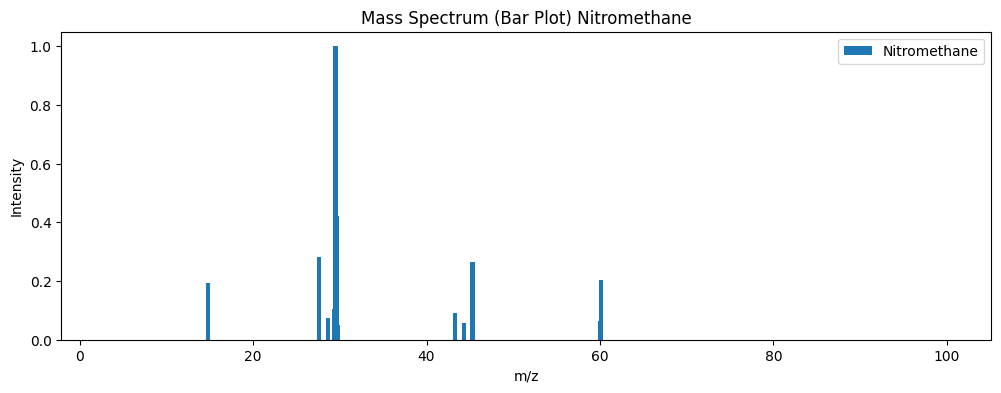

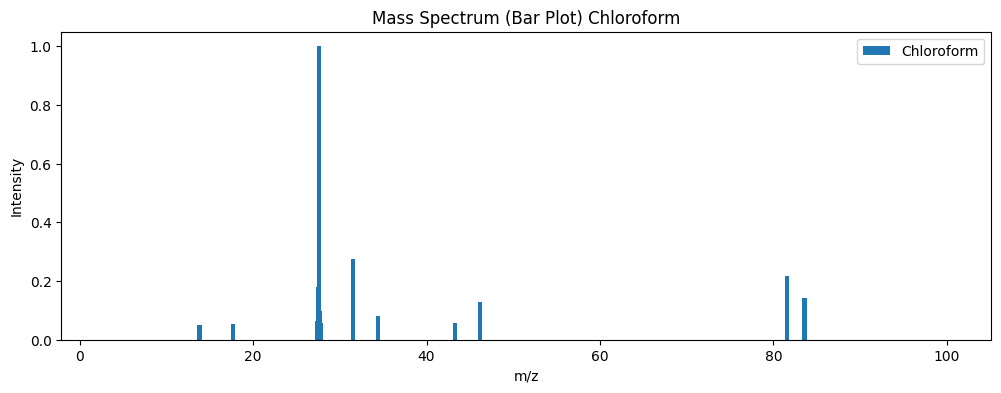

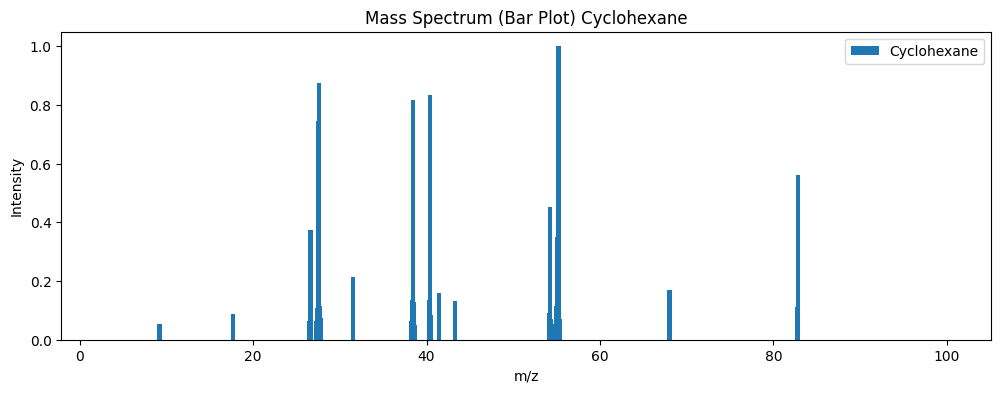

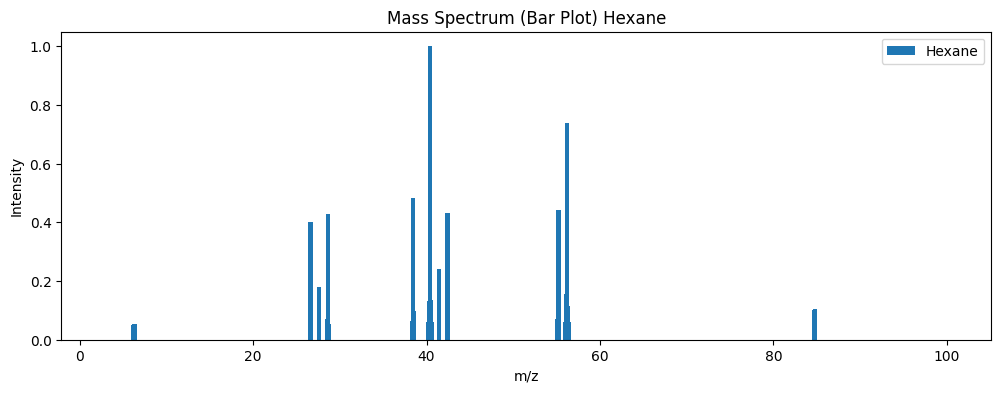

In [2]:
db_path = 'results/database_trap'
file_list = os.listdir(db_path)  # A list of all the files in the folder

spectra = []
for file in file_list:
    if file.endswith('.txt'):
        file_path = os.path.join(db_path, file)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            file_data = {}
            for line in lines:
                key, value = line.strip().split(': ')
                if key in ['mz', 'intensities']:
                    value = [float(v) for v in value[1:-1].split(', ')]
                elif key in ['id', 'array length']:
                    value = int(value)
                else:
                    value = value
                file_data[key] = value

            mz = file_data.pop('mz')
            intensities = file_data.pop('intensities')
            substance_name = file_data.pop('substance name')

            # Создание объекта Spectrum
            spectrum = Spectrum(mz, intensities, substance_name, **file_data)
            spectra.append(spectrum)

for spectrum in spectra:
    spectrum.barplot()

### Test spectrum

In [3]:
test_spectrum = random.choice(spectra)  # Select a random spectrum from the list
print(f'Test_spectrum: {test_spectrum.substance_name}')

Test_spectrum: Hexane


### Detect substance from the db

In [4]:
cos_measures = test_spectrum.cosine_measures_list(spectra)

# Results output
for measure in cos_measures:
    print(f"id: {measure['id']}, substance: {measure['substance_name']}, cosine measure: {measure['cm']:.4f}")

id: 1, substance: Nitromethane, cosine measure: 0.0419
id: 2, substance: Chloroform, cosine measure: 0.0986
id: 3, substance: Cyclohexane, cosine measure: 0.5783
id: 4, substance: Hexane, cosine measure: 1.0000


A substance is considered found if the cosine measure is greater than or equal to 0.9


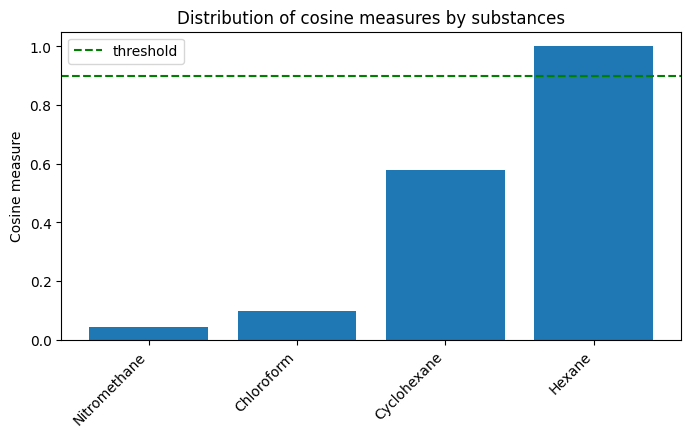

In [5]:
threshold = 0.9
names = [cos_measure['substance_name'] for cos_measure in cos_measures]
cms = [cos_measure['cm'] for cos_measure in cos_measures]

print(f'A substance is considered found if the cosine measure is greater than or equal to {threshold}')

plt.figure(figsize=(8,4))
plt.bar(range(len(cos_measures)), cms)
plt.axhline(y=threshold, color='green', linestyle='--', label='threshold')
plt.xticks(range(len(cos_measures)), names, rotation=45, ha='right')
plt.ylabel('Cosine measure')
plt.title('Distribution of cosine measures by substances')
plt.legend()
plt.show()